<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/vuelos_anac/vuelos_anac_arg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

# The Project: Vuelos en Argentina entre 2019 y 2024

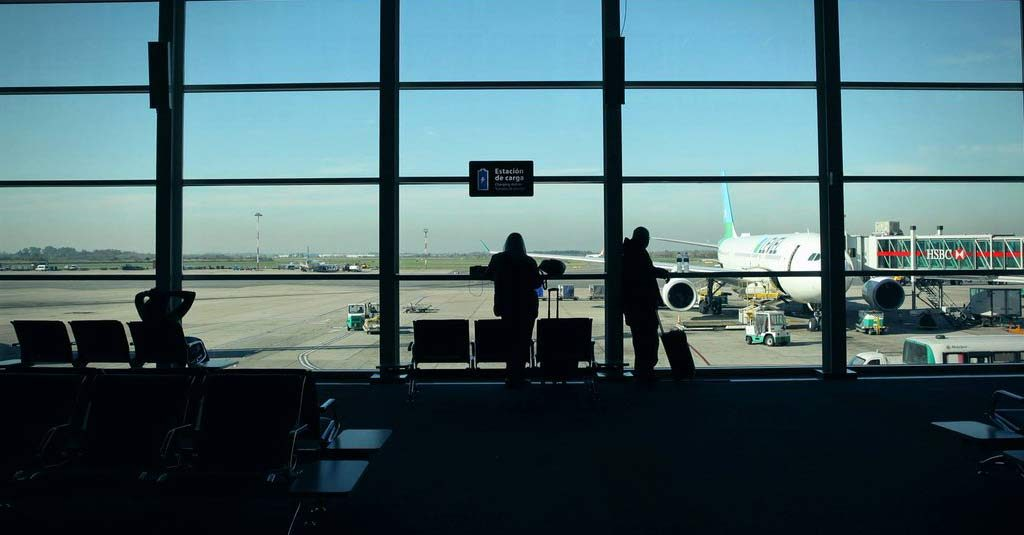

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Analysis to be performed
  1. Solution
1. Analytical context
  1. Requirements
  1. The Dataset
  1. Data set structure
  1. Data dimensions
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Backup
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values check
  1. Data type transformation
  1. Categorical variable labeling
  1. Feature engineering
  1. Outliers
  1. z-score method
  1. IQR method
  1. Secondary data set (optional)
  1. Save files
1. Exploratory Data Analysis (EDA)
  1. EDA Conclusions
1. Feature Selection
  1. Correlation matrix
  1. Stepwise
1. Model training
  1. Split the dataframe
1. Massive model training
  1. Models: Configuration
  1. Comparison
  1. ROC Raven
  1. Bias and Variance
1. Final project results
1. Conclusions and final recommendations
1. References
1. Change log

# Analytical context

### Data set structure

**Fecha**:
	Fecha ISO-8601 (date)
	Fecha de vuelo UTC

**Hora UTC**:
	Tiempo ISO-8601 (time)
	Hora UTC (Tiempo Universal Coordinado) . Al evaluar el dato, considerar que Argentina tiene hora oficial UTC -3.  

**Clase de Vuelo (todos los vuelos)**:
	Texto (string)
	Categorías de vuelos

**Clasificación Vuelo**:
	Texto (string)
	Clasificación del tipo de vuelo: Cabotaje o Internacional  

**Tipo de Movimiento**:
	Texto (string)
	Clasificación del tipo de movimiento. Se considera “Movimiento” a una operación, sea aterrizaje o despegue.

**Aeropuerto**:
	Texto (string)
	Nombre del aeropuerto código FAA  

**Origen/Destino**:
	Texto (string)
	Se utiliza el código FAA para aeropuertos nacionales y OACI para aeropuertos extranjeros.  

**Aerolínea Nombre**:
	Texto (string)
	Nombre de la línea aérea  

**Aeronave**:
	Texto (string)
	Código para identificar a los fabricantes de la aeronaves con la designación específica del modelo del avión.

**Pasajeros**:
	Número entero (integer)
	Cantidad de pasajeros operación individual (despegue/aterrizaje). Para vuelos de cabotaje se registra despegue y aterrizaje. Al analizar un Aeropuerto individual se debe tomar el dato de esta columna

**PAX**:
	Número entero (integer)
	1pax=1tarjeta de embarque. Usar esta columna al analizar la cantidad de pasajeros cabotaje a nivel total país. Al analizar los pasajeros internacionales es indiferente usar esta columna o la anterior.

**Calidad dato**:
	Texto (string)
	La información de los últimos 3 meses es provisoria  




**Notas**:

Existen también los IATA (que identifican a aeropuertos con servicio aéreo comercial regular o no regular de pasajeros y/o carga, y el OACI que es el código que asigna OACI a los aeropuertos más importantes; pero los aeródromos de menor categoría (aeroclubes, aeródromos privados, y/o aeródromos de uso exclusivo de aviación general) no tienen asignados códigos IATA ni OACI por no revestir la importancia mínima requerida. Por eso TODOS los aeródromos HABILITADOS en la República Argentina tienen en primer lugar un código otorgado por la autoridad aeronáutica de aplicación (actualmente la Administración Nacional de Aviación Civil (Argentina)) en el momento de la habilitación. A su vez si el aeropuerto reviste la importancia requerida, la Autoridad asigna a su vez un código OACI también. El código IATA depende de una organización comercial de orden privado y se asigna sólo cuando el aeropuerto tiene la actividad que torna necesaria la asignación de un código que determina su ingreso al circuito de operadores comerciales afiliados a la organización.

**Fuente**:

https://es.wikipedia.org/wiki/C%C3%B3digo_de_aeropuertos_de_la_Fuerza_A%C3%A9rea_Argentina

**Trabajo aéreo**: Según el Reglamento de Circulación Aérea​ los trabajos aéreos son aquellas operaciones de aeronave en la que ésta se aplica a servicios especializados tales como agricultura, construcción, fotografía, levantamiento de planos, observación y patrulla, búsqueda y salvamento, anuncios aéreos, etc…

### Libraries used

In [ ]:
# Visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Manipulación y análisis de datos
import numpy as np
import pandas as pd

# Otros
import datetime
from datetime import datetime, timedelta
import re

# Configura la zona horaria local
import pytz

# Configuración adicional
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

# File import
import requests
from openpyxl import load_workbook
from io import BytesIO

### Setting

In [ ]:
# Configura la zona horaria local
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

### Functions

In [ ]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    Esta función muestra la fecha y hora local cada vez que es invocada.
    :param local_timezone: La zona horaria local deseada (por defecto, 'America/Argentina/Buenos_Aires').
    :return: La fecha y hora local en el formato especificado.
    '''
    try:
        # Obtiene la hora local actual en UTC
        utc_now = datetime.utcnow()

        # Convierte la hora actual a la hora local
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Formato de salida para la fecha y hora local
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Retorna la fecha y hora local formateada
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # En caso de error, imprime el error y retorna None
        print("Error al obtener la fecha y hora local:", str(e))
        return None

In [ ]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [ ]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

In [ ]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Almacena físicamente los datos obtenidos en un archivo CSV.
    :param nombre_archivo: El nombre base del archivo CSV.
    :param df: El DataFrame que se desea guardar en el archivo CSV.
    '''
    try:
        # Obtiene la fecha y hora actual para agregarla al nombre del archivo
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Especifica la ruta y el nombre del archivo CSV
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Guarda el DataFrame en un archivo CSV sin incluir el índice
        df.to_csv(ruta_archivo_csv, index=False)

        # Imprime la fecha y hora de guardado y la ruta del archivo
        print("Fecha y hora:", fecha_y_hora_actual)
        print(f"Los datos se han guardado en el archivo CSV: {ruta_archivo_csv}")

    except Exception as error:
        # Maneja cualquier error que pueda ocurrir durante el proceso de guardado
        print(f"Ocurrió un error al guardar los datos en el archivo CSV: {error}")

In [ ]:
def validar_rango_datos(df, column_name, min_value, max_value):
    """
    Función para verificar si hay valores fuera de un rango especificado en una columna de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna que se va a verificar.
    - min_value: Valor mínimo permitido en la columna.
    - max_value: Valor máximo permitido en la columna.

    Retorna:
    - filtered_values: DataFrame que contiene las filas con valores fuera del rango especificado.
    """
    # Filtrar los valores que están fuera del rango especificado
    filtered_values = df[(df[column_name] < min_value) | (df[column_name] > max_value)]

    # Verificar si no hay errores
    if filtered_values.empty:
        print('Esta característica no presenta errores')
        return None
    else:
        print('Se detectaron errores:')
        return filtered_values

In [ ]:
def calcular_porcentage(df: pd.DataFrame, column_name: str):
    """
    Calcula el porcentaje de cada valor único en una columna de un DataFrame.

    Parámetros:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column_name (str): El nombre de la columna para la cual se calcularán los porcentajes.

    Retorna:
    pandas.Series: Una serie que contiene los porcentajes de cada valor único en la columna.
    """
    # Verificar si la columna existe en el DataFrame
    if column_name not in df.columns:
        print(f"La columna '{column_name}' no existe en el DataFrame.")
        return None

    # Obtener recuentos de valores únicos en la columna
    value_counts = df[column_name].value_counts()

    # Calcular los porcentajes
    percentages = (value_counts / len(df[column_name])) * 100

    # Asignar un nombre al índice para mayor claridad
    percentages = percentages.rename_axis(column_name)

    return percentages

## API

https://ourairports.com/airports/SAEZ/

https://developer.flightstats.com/api-docs/airports/v1

https://ourairports.com/data/

https://developer.flightstats.com/api-docs/airports/v1

OACI :
https://es.wikipedia.org/wiki/Organizaci%C3%B3n_de_Aviaci%C3%B3n_Civil_Internacional




# Data acquisition

### Airports

In [ ]:
try:
    airports_file = 'https://raw.githubusercontent.com/omanofx/portfolio/main/vuelos_anac/airports.csv'

    df_airports_raw = pd.read_csv(airports_file, sep = ',')

    print(f"Number of rows: " ,len(df_airports_raw))
    print("CSV file has been uploaded successfully.\n")

    print("Fecha y hora:", fecha_hora_local(time_zone))

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)

Number of rows:  78784
CSV file has been uploaded successfully.

Fecha y hora: 2024-05-07 13:45:35


In [ ]:
df_airports_raw.sample(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
10744,15860,9NE9,small_airport,Dog Leg Airport,40.194401,-97.567001,1500.0,NaN,US,US-NE,Hebron,no,9NE9,NaN,9NE9,NaN,NaN,NaN
17033,506547,CA-0839,small_airport,Île Sainte-Marguerite Airport,47.031730,-70.625710,23.0,NaN,CA,CA-QC,Saint-Antoine-de-l'Isle-aux-Grues,no,NaN,NaN,NaN,NaN,NaN,NaN
46493,348884,MX-1711,closed,La Huérfana Airport,29.344530,-101.724470,2220.0,NaN,MX,MX-COA,Ciudad Acuña,no,NaN,NaN,NaN,NaN,NaN,NaN
318,6791,04SC,heliport,Emergency Helipad,34.842188,-82.607140,994.0,NaN,US,US-SC,Easley,no,04SC,NaN,04SC,NaN,NaN,Easley Baptist Hospital
12097,42858,AR-0436,small_airport,La Esmeralda Airport,-29.993900,-57.837800,265.0,SA,AR,AR-W,Libertad,no,NaN,NaN,LLE,NaN,NaN,NaN


In [ ]:
df_airports_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78784 entries, 0 to 78783
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 78784 non-null  int64  
 1   ident              78784 non-null  object 
 2   type               78784 non-null  object 
 3   name               78784 non-null  object 
 4   latitude_deg       78784 non-null  float64
 5   longitude_deg      78784 non-null  float64
 6   elevation_ft       64023 non-null  float64
 7   continent          41192 non-null  object 
 8   iso_country        78525 non-null  object 
 9   iso_region         78784 non-null  object 
 10  municipality       73796 non-null  object 
 11  scheduled_service  78784 non-null  object 
 12  gps_code           42377 non-null  object 
 13  iata_code          9079 non-null   object 
 14  local_code         33326 non-null  object 
 15  home_link          3970 non-null   object 
 16  wikipedia_link     116

In [ ]:
df_airports = df_airports_raw.copy()

In [ ]:
try:
    df_airports.drop(columns=['id','scheduled_service','elevation_ft',
                              'home_link', 'wikipedia_link', 'keywords',
                              'ident','continent'],
                    inplace=True)
    print("Selected columns were successfully deleted.")
except Exception as e:
    print("An error occurred while deleting columns from the dataframe:", e)

Selected columns were successfully deleted.


In [ ]:
# mostrar unicamente los valores duplicados df_airports
df_airports[df_airports.duplicated(keep=False)]

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
5420,closed,Rafter R Ranch Airport,35.424140,-95.496200,US,US-OK,Checotah,NaN,NaN,NaN
11024,small_airport,Woodland Airpark,15.254326,120.677772,PH,PH-PAM,Magalang,NaN,NaN,NaN
13103,closed,dont know if this is an airport,-22.368055,143.026875,AU,AU-QLD,Winston,NaN,NaN,NaN
13104,closed,dont know if this is an airport,-22.368055,143.026875,AU,AU-QLD,Winston,NaN,NaN,NaN
16995,heliport,Kamloops RCMP Helipad,50.655236,-120.366222,CA,CA-BC,Kamloops,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
73093,heliport,Soshone Mountain Helipad,36.925262,-116.219974,US,US-NV,Nye,NaN,NaN,NaN
73156,small_airport,Custer Army Airfield,39.235860,-96.936879,US,US-KS,Fort Riley,NaN,NaN,NaN
73157,small_airport,Custer Army Airfield,39.235860,-96.936879,US,US-KS,Fort Riley,NaN,NaN,NaN
78091,small_airport,Benics Airport,-25.818899,29.221701,ZA,ZA-MP,Witbank,NaN,NaN,NaN


In [ ]:
# Elimina los registros duplicados
total_airports_duplicados = df_airports.duplicated().sum()

if total_airports_duplicados > 0:
    print("Total duplicate observations in the DataFrame:", total_airports_duplicados)
    df_airports.drop_duplicates(inplace=True)
    print("Duplicate observations were removed.")
else:
    print("The DataFrame has no duplicate observations.")

Total duplicate observations in the DataFrame: 104
Duplicate observations were removed.


In [ ]:
# Eliminar registros donde las tres columnas gps_code, iata_code y local_code sean NaN
df_airports = df_airports.dropna(subset=['gps_code', 'iata_code', 'local_code'], how='all')
df_airports

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
0,heliport,Total RF Heliport,40.070985,-74.933689,US,US-PA,Bensalem,K00A,NaN,00A
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,US,US-KS,Leoti,00AA,NaN,00AA
2,small_airport,Lowell Field,59.947733,-151.692524,US,US-AK,Anchor Point,00AK,NaN,00AK
3,small_airport,Epps Airpark,34.864799,-86.770302,US,US-AL,Harvest,00AL,NaN,00AL
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,US,US-AK,King Salmon,00AN,NaN,00AN
...,...,...,...,...,...,...,...,...,...,...
78776,medium_airport,Yanji Chaoyangchuan Airport,42.882801,129.451004,CN,CN-22,Yanji,ZYYJ,YNJ,NaN
78777,medium_airport,Yingkou Lanqi Airport,40.542524,122.358600,CN,CN-21,"Laobian, Yingkou",ZYYK,YKH,NaN
78778,medium_airport,Shenyang Dongta Airport,41.784401,123.496002,CN,CN-21,"Dadong, Shenyang",ZYYY,NaN,NaN
78781,small_airport,Fainting Goat Airport,32.110587,-97.356312,US,US-TX,Blum,87TX,NaN,87TX


In [ ]:
# Aeropuertos ARG sin código local
df_airports.query('iso_country =="AR" & local_code.isna()')

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
11689,small_airport,Tandil Aeroclub Airport,-37.265598,-59.093300,AR,AR-B,Tandil,SA1B,NaN,NaN
12054,small_airport,Comandante Eduardo A. Olivero Airport,-37.347686,-58.985300,AR,AR-B,Tandil,SA1A,NaN,NaN
54333,small_airport,Puerto Rosales Airport,-38.897099,-62.010300,AR,AR-B,Puerto Rosales,SA27,NaN,NaN
54345,small_airport,Aeródromo El Colorado,-26.316687,-59.339764,AR,AR-P,El Colorado,SA41,NaN,NaN


In [ ]:
# eliminar de df_airports cuando 'iso_country' sea 'AR' y local_code sea nan
df_airports = df_airports[~((df_airports['iso_country'] == 'AR') & (df_airports['local_code'].isna()))]

In [ ]:
# Origen/Destino: Texto (string) Se utiliza el código FAA para aeropuertos nacionales y OACI para aeropuertos extranjeros.
#df_airports.query('local_code in ("FDO", "DOZ")')

In [ ]:
# Origen/Destino: Texto (string) Se utiliza el código FAA para aeropuertos nacionales y OACI para aeropuertos extranjeros.
#df_airports.query('gps_code in ("SBGR", "SULS","FDO", "DOZ", "SCEL")')

In [ ]:
# Origen/Destino: Texto (string) Se utiliza el código FAA para aeropuertos nacionales y OACI para aeropuertos extranjeros.
#df_airports.query('iata_code in ("EZE", "SIS", "AER", "IGU", "AER")')

In [ ]:
df_airports

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
0,heliport,Total RF Heliport,40.070985,-74.933689,US,US-PA,Bensalem,K00A,NaN,00A
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,US,US-KS,Leoti,00AA,NaN,00AA
2,small_airport,Lowell Field,59.947733,-151.692524,US,US-AK,Anchor Point,00AK,NaN,00AK
3,small_airport,Epps Airpark,34.864799,-86.770302,US,US-AL,Harvest,00AL,NaN,00AL
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,US,US-AK,King Salmon,00AN,NaN,00AN
...,...,...,...,...,...,...,...,...,...,...
78776,medium_airport,Yanji Chaoyangchuan Airport,42.882801,129.451004,CN,CN-22,Yanji,ZYYJ,YNJ,NaN
78777,medium_airport,Yingkou Lanqi Airport,40.542524,122.358600,CN,CN-21,"Laobian, Yingkou",ZYYK,YKH,NaN
78778,medium_airport,Shenyang Dongta Airport,41.784401,123.496002,CN,CN-21,"Dadong, Shenyang",ZYYY,NaN,NaN
78781,small_airport,Fainting Goat Airport,32.110587,-97.356312,US,US-TX,Blum,87TX,NaN,87TX


### Flights

In [ ]:
# Lista de atributos para la obtención de cada dataset por año
url_files = [
    {
        "year": 2019,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/aa8337de-3565-4ecf-9cd9-6f1c61f8f0ed/download/2019_informe_ministerio.csv",
        "separator": ";"
    },
    {
        "year": 2020,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/d0e75e7d-e416-470f-bedb-ef2a877cbae3/download/2020_informe_ministerio.csv",
        "separator": ";"

    },
    {
        "year": 2021,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/1b4f569a-cab0-4560-993c-5bf96c3e7cf0/download/202112_informe_ministerio.csv",
        "separator": ","
    },
    {
        "year": 2022,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/11894a35-de36-4579-b084-d1191f551fbe/download/202212-informe-ministerio.csv",
        "separator": ";"
    },
    {
        "year": 2023,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/e910fead-ade3-40ce-ae8f-cad2017aa007/download/202312-informe-ministerio-actualizado-dic.csv",
        "separator": ";"
    },
    {
        "year": 2024,
        "url": "https://datos.transporte.gob.ar/dataset/21038a1a-c3c7-4494-b76a-3a2a8fbb83b5/resource/6004191c-83ca-4a0a-a687-c059bb0a8c8e/download/202403-informe-ministerio.csv",
        "separator": ";"
    }
]

In [ ]:
# Version 2
try:
    # Lista para almacenar los DataFrames procesados
    list_of_df = []

    columns_names = ['Fecha', 'Hora UTC', 'Clase de vuelos (todos los vuelos)', 'Clasificacion Vuelo',
                     'Tipo Movimiento', 'Aeropuerto', 'Origen/Destino',
                     'Aerolinea Nombre', 'Aeronave', 'Pasajeros', 'PAX', 'Calidad del dato']

    print(" --- Loop Start --- \n")
    # leer cada item de la lista url_files
    for file in url_files:
        #print(file["year"], file["url"], file["separator"])

        print("Processing year: " + str(file["year"]), " - News found")
        print(50 * "-")
        # Leer el archivo CSV desde la URL
        df_temp = pd.read_csv(file["url"], sep = file["separator"], header = 1,  encoding='utf-8')

        # Añadir el nombre de las columnas al DataFrame
        df_temp.columns = columns_names

        # Añadir el DataFrame a la lista
        list_of_df.append(df_temp)

        # Imprimir el año y el número de filas en el DataFrame
        print(f" Year:", str(file["year"]), "Number of rows: " ,len(df_temp))
        print(" CSV file has been uploaded successfully.\n")

        print(f"End of file\n")

    # Concatenar todos los DataFrames en la lista
    df_vuelos_raw = pd.concat(list_of_df, ignore_index=True)

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)


 --- Loop Start --- 

Processing year: 2019  - News found
--------------------------------------------------
 Year: 2019 Number of rows:  580773
 CSV file has been uploaded successfully.

End of file

Processing year: 2020  - News found
--------------------------------------------------
 Year: 2020 Number of rows:  212725
 CSV file has been uploaded successfully.

End of file

Processing year: 2021  - News found
--------------------------------------------------
 Year: 2021 Number of rows:  328135
 CSV file has been uploaded successfully.

End of file

Processing year: 2022  - News found
--------------------------------------------------
 Year: 2022 Number of rows:  477084
 CSV file has been uploaded successfully.

End of file

Processing year: 2023  - News found
--------------------------------------------------
 Year: 2023 Number of rows:  557151
 CSV file has been uploaded successfully.

End of file

Processing year: 2024  - News found
-----------------------------------------------

In [ ]:
df_vuelos_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300855 entries, 0 to 2300854
Data columns (total 12 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   Fecha                               object
 1   Hora UTC                            object
 2   Clase de vuelos (todos los vuelos)  object
 3   Clasificacion Vuelo                 object
 4   Tipo Movimiento                     object
 5   Aeropuerto                          object
 6   Origen/Destino                      object
 7   Aerolinea Nombre                    object
 8   Aeronave                            object
 9   Pasajeros                           int64 
 10  PAX                                 object
 11  Calidad del dato                    object
dtypes: int64(1), object(11)
memory usage: 210.6+ MB


In [ ]:
grabar_csv("vuelos_anac_raw", df_vuelos_raw)

Fecha y hora: 2024-05-07 13:48:26
Los datos se han guardado en el archivo CSV: vuelos_anac_raw_2024-05-07 13:48:26.csv


# Data wrangling

In [ ]:
df_vuelos_raw.sample(5)

,Fecha,Hora UTC,Clase de vuelos (todos los vuelos),Clasificacion Vuelo,Tipo Movimiento,Aeropuerto,Origen/Destino,Aerolinea Nombre,Aeronave,Pasajeros,PAX,Calidad del dato
1409506,15/08/2022,15:59,Vuelo Privado con Matrícula Nacional,Internacional,Aterrizaje,FDO,SULS,0,TXA-525,0,0,DEFINITIVO
150051,1/4/2019,11:31:00,REGULAR,Doméstico,Aterrizaje,TUC,AER,AEROLINEAS ARGENTINAS SA,BO-737-76N,190,95,DEFINITIVO
2060429,30/10/2023,11:14,Regular,Doméstico,Aterrizaje,DOZ,AER,AEROLINEAS ARGENTINAS SA,BO-737-800,149,75,DEFINITIVO
1607119,07/01/2023,12:10,Regular,Doméstico,Despegue,DOZ,AER,FB LÍNEAS AÉREAS - FLYBONDI,BO-737-8Q8,169,85,DEFINITIVO
391658,1/9/2019,14:04:00,REGULAR,Doméstico,Despegue,CRV,AER,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,166,83,DEFINITIVO


In [146]:
# Copia para procesar los datos obtenidos.
df_vuelos = df_vuelos_raw.copy()

In [147]:
# Renombrar características
df_vuelos.rename(columns={'Fecha': 'date',
                          'Hora UTC': 'time_utc',
                          'Aeropuerto': 'airport_arg',
                          'Clasificacion Vuelo': 'international_flight',
                          'Clase de vuelos (todos los vuelos)': 'flight_type',
                          'Tipo Movimiento': 'landing',
                          'Origen/Destino': 'origin_destination',
                          'Aerolinea Nombre': 'airline_name',
                          'Aeronave': 'aircraft',
                          'Pasajeros': 'passengers',
                          'PAX': 'pax',
                          'Calidad del dato': 'data_quality'}, inplace=True)

In [148]:
df_vuelos.sample(5)

,date,time_utc,flight_type,international_flight,landing,airport_arg,origin_destination,airline_name,aircraft,passengers,pax,data_quality
600351,14/1/2020,18:35,Regular,Doméstico,Despegue,DOZ,CBA,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,0,78,39,DEFINITIVO
1686902,02/03/2023,0:30,Regular,Internacional,Aterrizaje,EZE,SBGL,FB LÍNEAS AÉREAS - FLYBONDI,BO-737-86N,170,170,DEFINITIVO
2151215,28/12/2023,20:52,Regular,Doméstico,Despegue,PAR,AER,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,82,41,DEFINITIVO
1109627,21/12/2021,17:14,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,CHP,LNH,0,AIR-AT-802A,0,0,DEFINITIVO
2093111,20/11/2023,19:59,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,FDO,FDO,0,PA-PA-28-181,0,0,DEFINITIVO


## Duplicate values

In [149]:
total_duplicados = df_vuelos.duplicated().sum()

if total_duplicados > 0:
    print("En total de observaciones duplicadas en el DataFrame:", total_duplicados)
    df_vuelos.drop_duplicates(inplace=True)
    print("Se eliminaron las observaciones duplicadas.")
else:
    print("El DataFrame no tiene observaciones duplicadas.")

En total de observaciones duplicadas en el DataFrame: 4596
Se eliminaron las observaciones duplicadas.


## NaN values

In [150]:
df_vuelos['landing'].unique()

array(['Aterrizaje', 'Despegue', nan], dtype=object)

In [151]:
# Elimina los registros con type movement en NaN
df_vuelos = df_vuelos.dropna(subset=['landing'])

In [211]:
# Reemplaza los valores NaN
df_vuelos['airline_name'].fillna('unknown', inplace=True)
df_vuelos['airline_name'].replace('0', 'unknown', inplace=True)

df_vuelos['aircraft'].fillna('unknown', inplace=True)
df_vuelos['aircraft'].replace('0', 'unknown', inplace=True)

# Elimina los registros cuando 'tipo movimiento' sea NaN
df_vuelos = df_vuelos[df_vuelos['landing'].notna()]

## Data type transformation

In [153]:
# borrar

df_backup_1 = df_vuelos.copy()

In [154]:
#borrar
df_vuelos = df_backup_1.copy()

In [155]:
# Convert the 'date' column to datetime format using ISO-8601
df_vuelos['date'] = pd.to_datetime(df_vuelos['date'], format="%d/%m/%Y")

In [156]:
# Busca el tamaño de los tipos de formatos de fechas existentes
df_vuelos['time_utc'].str.len().unique()

array([8, 5, 4])

In [157]:
# Aplicar lambda cuando la longitud de 'time_utc' sea 8, y eliminar ':00' del final
df_vuelos['time_utc'] = df_vuelos['time_utc'].apply(lambda x: x[:-3] if len(x) == 8 and x.endswith(':00') else x)

In [158]:
# Convert the 'time_utc' column to datetime format using ISO-8601
df_vuelos['time_utc'] = pd.to_datetime(df_vuelos['time_utc'], format="%H:%M")

In [212]:
df_vuelos.sample(5)

,date,time_utc,flight_type,international_flight,landing,airline_name,aircraft,passengers,pax,airport_destination,airport_origin,day,month,year
762695,2020-11-15,1900-01-01 21:27:00,no regular,0,0,unknown,BE-A36,0,0,FDO,JUA,15,11,2020
2075403,2023-11-09,1900-01-01 11:51:00,regular,0,1,AEROLINEAS ARGENTINAS SA,BO-B737-800,169,85,SAL,EZE,9,11,2023
1057964,2021-11-09,1900-01-01 15:09:00,privado con matricula nacional,0,0,unknown,PA-PA-28-181,0,0,FDO,FDO,9,11,2021
1524225,2022-11-05,1900-01-01 13:47:00,regular,0,0,FB LÍNEAS AÉREAS - FLYBONDI,BO-737-86N,181,91,AER,IGU,5,11,2022
1375157,2022-07-22,1900-01-01 07:24:00,regular,0,1,AEROLINEAS ARGENTINAS SA,BO-737-8SH,171,86,AER,BAR,22,7,2022


In [213]:
df_vuelos['international_flight'].unique()

array([1, 0])

In [161]:
# Si el vuelo es Internacional = 1
df_vuelos['international_flight'].replace('Internacional', 1, inplace=True)
df_vuelos['international_flight'].replace('Inter', 1, inplace=True)

# Si es Domestico = 0
df_vuelos['international_flight'].replace('Dom', 0, inplace=True)
df_vuelos['international_flight'].replace('Doméstico', 0, inplace=True)

In [162]:
# Ahora transforma la característica en Int
df_vuelos['international_flight'] = df_vuelos['international_flight'].astype(int)

In [163]:
df_vuelos['landing'].unique()

array(['Aterrizaje', 'Despegue'], dtype=object)

In [164]:
df_vuelos['landing'].replace("Aterrizaje", 1, inplace=True)
df_vuelos['landing'].replace("Despegue", 0, inplace=True)

In [165]:
df_vuelos['landing'] = df_vuelos['landing'].astype(int)

In [166]:
analizar_dataframe(df_vuelos, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,min,25%,50%,75%,max,std
date,datetime64[ns],2296256,0,0.000000,,0,False,2296256,2021-10-03 20:44:10.533737984,2019-01-01 00:00:00,2019-12-27 00:00:00,2022-01-31 00:00:00,2023-03-26 00:00:00,2024-03-31 00:00:00,nan
time_utc,datetime64[ns],2296256,0,0.000000,,0,False,2296256,1900-01-01 14:49:20.823478272,1900-01-01 00:00:00,1900-01-01 11:59:00,1900-01-01 15:34:00,1900-01-01 19:27:00,1900-01-01 23:59:00,nan
flight_type,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
international_flight,int64,2296256,0,0.000000,,1911073,False,2296256.000000,0.167744,0.000000,0.000000,0.000000,0.000000,1.000000,0.373639
landing,int64,2296256,0,0.000000,,1156778,False,2296256.000000,0.496233,0.000000,0.000000,0.000000,1.000000,1.000000,0.499986
airport_arg,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
origin_destination,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airline_name,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
aircraft,object,2296256,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
passengers,int64,2296256,0,0.000000,,828261,False,2296256.000000,85.769946,0.000000,0.000000,68.000000,159.000000,1626.000000,95.231666


In [167]:
df_vuelos['time_utc'].value_counts()

time_utc
1900-01-01 15:00:00    3790
1900-01-01 14:00:00    3691
1900-01-01 13:00:00    3629
1900-01-01 16:00:00    3603
1900-01-01 12:00:00    3427
                       ... 
1900-01-01 05:54:00     197
1900-01-01 06:39:00     194
1900-01-01 06:29:00     192
1900-01-01 06:34:00     188
1900-01-01 06:31:00     187
Name: count, Length: 1440, dtype: int64

In [168]:
# Aeropuertos en Argentina
df_vuelos['airport_arg'].unique()

array(['EZE', 'AER', 'TUC', 'MDP', 'DOZ', 'CBA', 'IGU', 'PAL', 'FDO',
       'ROS', 'BAR', 'SAL', 'NEU', 'ECA', 'GRA', 'SVO', 'JUJ', 'TRC',
       'GAL', 'POS', 'STR', 'OSA', 'USU', 'BCA', 'TRE', 'SIS', 'FSA',
       'SRA', 'VIE', 'CRV', 'CAT', 'ESQ', 'CHP', 'RTA', 'DRY', 'PAR',
       'JUA', 'CRR', 'SDE', 'MOR', 'UIS', 'LAR', 'MLG', 'DIL', 'BAL',
       'RYD', 'DIA', 'TRH', 'GOY', 'GPI', 'PTA', 'MDB', 'ARS', 'DOL',
       'HDO', 'NIN', 'EAU', 'RIN', 'CUT'], dtype=object)

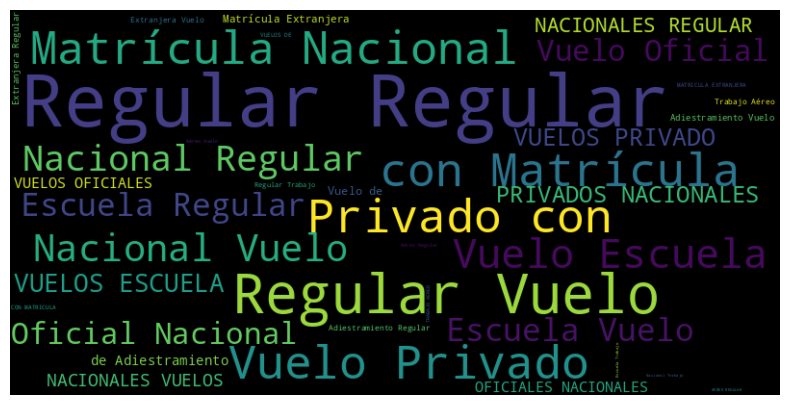

In [169]:
# mostar una nube de palabras con df_vuelos['flight_type´]

# Generate the word cloud
wordcloud = WordCloud(width=800,
                      height=400).generate(' '.join(df_vuelos['flight_type']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [170]:
sorted(df_vuelos['flight_type'].unique())

['ESCUELA (NO VIGENTE)',
 'NO REGULAR',
 'No Regular',
 'REGULAR',
 'Regular',
 'TRABAJO AEREO',
 'Trabajo Aéreo',
 'VUELOS DE ADIESTRAMIENTO',
 'VUELOS ESCUELA',
 'VUELOS OFICIALES EXTRANJEROS',
 'VUELOS OFICIALES NACIONALES',
 'VUELOS PRIVADO CON MATRICULA EXTRANJERA',
 'VUELOS PRIVADOS NACIONALES',
 'Vuelo Escuela',
 'Vuelo Oficial Extranjero',
 'Vuelo Oficial Nacional',
 'Vuelo Privado con Matrícula Extranjera',
 'Vuelo Privado con Matrícula Nacional',
 'Vuelo de Adiestramiento']

In [171]:
# Transforma los datos a textos en minusculas
df_vuelos['flight_type'] = df_vuelos['flight_type'].str.lower()
df_vuelos['flight_type'].unique()

array(['regular', 'vuelos privados nacionales',
       'vuelos oficiales nacionales', 'no regular',
       'vuelos privado con matricula extranjera', 'trabajo aereo',
       'vuelos de adiestramiento', 'vuelos escuela',
       'vuelos oficiales extranjeros', 'escuela (no vigente)',
       'vuelo privado con matrícula nacional',
       'vuelo privado con matrícula extranjera', 'trabajo aéreo',
       'vuelo de adiestramiento', 'vuelo oficial extranjero',
       'vuelo oficial nacional', 'vuelo escuela'], dtype=object)

In [172]:
# quita los acentos de df_vuelos['flight_type']
df_vuelos['flight_type'] = df_vuelos['flight_type'].str.normalize('NFKD').str.encode('ascii',
                                                                                     errors='ignore').str.decode('utf-8')
df_vuelos['flight_type'].unique()

array(['regular', 'vuelos privados nacionales',
       'vuelos oficiales nacionales', 'no regular',
       'vuelos privado con matricula extranjera', 'trabajo aereo',
       'vuelos de adiestramiento', 'vuelos escuela',
       'vuelos oficiales extranjeros', 'escuela (no vigente)',
       'vuelo privado con matricula nacional',
       'vuelo privado con matricula extranjera',
       'vuelo de adiestramiento', 'vuelo oficial extranjero',
       'vuelo oficial nacional', 'vuelo escuela'], dtype=object)

In [173]:
# Busca y reemplaza cadenas de textos especificas para normalizar las categorías
replacements = {
    "escuela (no vigente)": "escuela",
    "vuelo de adiestramiento" : "escuela",
    "vuelos de adiestramiento": "escuela",
    "vuelos oficiales extranjeros": "vuelo oficial extranjero",
    "vuelos oficiales nacionales": "vuelo oficial nacional",
    "vuelos privados nacionales" : "vuelo privado con matricula nacional"
}

df_vuelos['flight_type'] = df_vuelos['flight_type'].replace(replacements)


In [174]:
# Lista de palabras a eliminar
palabras_a_eliminar = ["vuelo", "vuelos"]

# Patrón regex para encontrar palabras completas
patron_regex = r'\b(?:{})\b'.format('|'.join(palabras_a_eliminar))

# Reemplazar palabras completas
df_vuelos['flight_type'] = df_vuelos['flight_type'].str.replace(patron_regex, '', regex=True).str.strip()

# Mostrar los resultados ordenados finales
sorted(df_vuelos['flight_type'].unique())

['escuela',
 'no regular',
 'oficial extranjero',
 'oficial nacional',
 'privado con matricula extranjera',
 'privado con matricula nacional',
 'regular',
 'trabajo aereo']

In [175]:
df_backup_2 = df_vuelos.copy()

## Feature engineering

In [176]:
# Aplica Origen / Destino según si fue aterrizaje o despegue
df_vuelos.loc[df_vuelos['landing'] == 1, 'airport_destination'] = df_vuelos.loc[df_vuelos['landing'] == 1, 'airport_arg']
df_vuelos.loc[df_vuelos['landing'] == 1, 'airport_origin'] = df_vuelos.loc[df_vuelos['landing'] == 1, 'origin_destination']

df_vuelos.loc[df_vuelos['landing'] == 0, 'airport_destination'] = df_vuelos.loc[df_vuelos['landing'] == 0, 'origin_destination']
df_vuelos.loc[df_vuelos['landing'] == 0, 'airport_origin'] = df_vuelos.loc[df_vuelos['landing'] == 0, 'airport_arg']

# Validacion
df_vuelos[['landing', 'airport_arg', 'origin_destination', 'airport_origin', 'airport_destination']].sample(5)

,landing,airport_arg,origin_destination,airport_origin,airport_destination
735190,1,EZE,EZE,EZE,EZE
815728,0,EZE,SRA,EZE,SRA
1656627,1,ROS,SULS,SULS,ROS
1133197,1,POS,ELD,ELD,POS
1971266,1,CRR,AER,AER,CRR


In [177]:
# Check if the columns exist in the DataFrame
if all(col in df_vuelos.columns for col in ['airport_arg', 'origin_destination', 'data_quality']):
    # Drop the columns
    df_vuelos.drop(columns=['airport_arg', 'origin_destination', 'data_quality'], inplace=True)
else:
    print("The columns do not exist in the DataFrame.")


In [178]:
# Nuevas características
df_vuelos['day'] = df_vuelos['date'].dt.day
df_vuelos['month'] = df_vuelos['date'].dt.month
df_vuelos['year'] = df_vuelos['date'].dt.year

In [179]:
validar_rango_datos(df_vuelos, 'day', 1, 31)

Esta característica no presenta errores


In [180]:
validar_rango_datos(df_vuelos, 'month', 1, 12)

Esta característica no presenta errores


In [181]:
validar_rango_datos(df_vuelos, 'year', 2019, 2024)

Esta característica no presenta errores


In [182]:
df_backup_3 = df_vuelos.copy()

In [183]:
df_vuelos = df_backup_3.copy()

In [184]:
df_vuelos.sample(5)

,date,time_utc,flight_type,international_flight,landing,airline_name,aircraft,passengers,pax,airport_destination,airport_origin,day,month,year
1355997,2022-07-08,1900-01-01 16:05:00,regular,0,1,AEROLINEAS ARGENTINAS SA,BO-B-737-76N,96,48,AER,SVO,8,7,2022
2210168,2024-02-03,1900-01-01 16:52:00,privado con matricula nacional,0,0,0,CE-172-N,0,0,OBE,POS,3,2,2024
1733567,2023-03-30,1900-01-01 18:43:00,regular,0,0,AEROLINEAS ARGENTINAS SA,BO-B737-81D,121,61,CRR,AER,30,3,2023
1634615,2023-01-26,1900-01-01 17:22:00,regular,1,1,GOL LINHAS AÉREAS S.A.,0,158,158,DOZ,SBGR,26,1,2023
935996,2021-07-07,1900-01-01 08:53:00,no regular,0,0,AMERICAN JET S.A.,FA-SA-227-DC,8,4,VIE,JUA,7,7,2021


### Aeropuertos

In [185]:
df_local_flight = df_vuelos[['date', 'time_utc', 'flight_type',	'airline_name',	'aircraft',	'passengers',
                             'pax', 'day', 'month', 'year', 'landing','international_flight', 'airport_origin',
                             'airport_destination']].query('international_flight == 0')
df_local_flight.sample(5)

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,landing,international_flight,airport_origin,airport_destination
1831947,2023-06-02,1900-01-01 04:12:00,regular,AMERICAN JET S.A.,EMB-EMB-145LR,50,25,2,6,2023,1,0,JUA,AER
1218859,2022-03-29,1900-01-01 10:15:00,regular,AEROLINEAS ARGENTINAS SA,BO-B-737-7BD,118,59,29,3,2022,1,0,EZE,NEU
870128,2021-04-06,1900-01-01 18:00:00,privado con matricula nacional,0,PA-PA-34-200-T,0,0,6,4,2021,0,0,NEU,OEL
1382265,2022-07-28,1900-01-01 04:35:00,no regular,0,LJ-35-A,0,0,28,7,2022,1,0,NEU,FDO
1788882,2023-05-04,1900-01-01 14:31:00,regular,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,78,39,4,5,2023,1,0,AER,CAT


In [186]:
df_airports_arg = df_airports.query('iso_country == "AR"')
df_airports_arg.sample(5)

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
9600,small_airport,Cipoletti Aeroclub Airport,-38.893101,-67.988602,AR,AR-R,Cipoletti,SAHI,NaN,CIP
33838,small_airport,Caviahue Airport,-37.851398,-71.009201,AR,AR-Q,Lafontaine,SAHE,CVH,CVH
9851,small_airport,La Igualdad Airport,-35.513300,-58.353100,AR,AR-B,Ranchos,NaN,NaN,RAI
9664,small_airport,Chivilcoy Airport,-34.963900,-60.033300,AR,AR-B,Chivilcoy,SA4B,NaN,CHY
33886,medium_airport,Orán Airport,-23.152800,-64.329201,AR,AR-A,Orán,SASO,ORA,ORA


In [187]:
# Aeropuertos nacionales
df_local = pd.merge(left = df_local_flight,
                     right = df_airports_arg,
                     left_on = 'airport_origin',
                     right_on = 'local_code',
                     how = 'left')

df_local = pd.merge(left = df_local,
                     right = df_airports_arg,
                     left_on = 'airport_destination',
                     right_on = 'local_code',
                     how = 'left',
                     suffixes = ('_origin', '_destination'))

df_local.sample(5)

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,...,type_destination,name_destination,latitude_deg_destination,longitude_deg_destination,iso_country_destination,iso_region_destination,municipality_destination,gps_code_destination,iata_code_destination,local_code_destination
661405,2021-01-18,1900-01-01 12:56:00,oficial nacional,0,0,2,1,18,1,2021,...,medium_airport,El Palomar Airport,-34.609900,-58.612600,AR,AR-B,El Palomar,SADP,EPA,PAL
1142015,2022-07-08,1900-01-01 19:00:00,escuela,0,CE-150,0,0,8,7,2022,...,medium_airport,El Tehuelche Airport,-42.759200,-65.102700,AR,AR-U,Puerto Madryn,SAVY,PMY,DRY
455617,2019-12-14,1900-01-01 21:16:00,escuela,unknown,CE-150-L,0,0,14,12,2019,...,small_airport,Zarate Airport,-34.119912,-59.083198,AR,AR-B,Zarate,SA2L,NaN,ATE
1885638,2024-03-11,1900-01-01 14:53:00,regular,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,96,48,11,3,2024,...,medium_airport,El Plumerillo Airport,-32.831699,-68.792900,AR,AR-M,Mendoza,SAME,MDZ,DOZ
947258,2022-01-06,1900-01-01 19:13:00,regular,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,95,48,6,1,2022,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.415600,AR,AR-C,Buenos Aires,SABE,AEP,AER


In [188]:
df_pruebas = df_vuelos[['date', 'time_utc', 'flight_type',	'airline_name',	'aircraft',	'passengers',
                             'pax', 'day', 'month', 'year', 'landing','international_flight', 'airport_origin',
                             'airport_destination']].query('international_flight == 1 & landing == 1')
df_pruebas.sample(5)

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,landing,international_flight,airport_origin,airport_destination
1509703,2022-10-25,1900-01-01 21:29:00,privado con matricula extranjera,0,0,2,2,25,10,2022,1,1,SUAA,FDO
1201980,2022-03-15,1900-01-01 11:36:00,regular,UNITED AIRLINES INC. (EEUU),0,246,246,15,3,2022,1,1,KIAH,EZE
2198567,2024-01-27,1900-01-01 14:28:00,regular,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,60,60,27,1,2024,1,1,SUMU,AER
873162,2021-04-10,1900-01-01 13:00:00,regular,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,236,236,10,4,2021,1,1,LEMD,EZE
511595,2019-11-16,1900-01-01 19:07:00,regular,AZUL LINEA AEREA,unknown,789,789,16,11,2019,1,1,SBRF,ROS


In [189]:
# Aeropuertos internacionales
df_international = pd.merge(left = df_pruebas,
                            right = df_airports,
                            left_on = 'airport_origin',
                            right_on = 'gps_code',
                            how = 'left')

df_international = pd.merge(left = df_international,
                            right = df_airports_arg,
                            left_on = 'airport_destination',
                            right_on = 'local_code',
                            how = 'left',
                            suffixes = ('_origin', '_destination'))

df_international.sample(5)

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,...,type_destination,name_destination,latitude_deg_destination,longitude_deg_destination,iso_country_destination,iso_region_destination,municipality_destination,gps_code_destination,iata_code_destination,local_code_destination
164343,2023-10-14,1900-01-01 04:00:00,regular,AEROLINEAS ARGENTINAS SA,BO-737-8,138,138,14,10,2023,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.415600,AR,AR-C,Buenos Aires,SABE,AEP,AER
131546,2023-02-07,1900-01-01 18:17:00,trabajo aereo,HELICOPTEROS DEL PACIFICO,AIR-AT-802,0,0,7,2,2023,...,medium_airport,Brigadier Antonio Parodi Airport,-42.908001,-71.139503,AR,AR-U,Esquel,SAVE,EQS,ESQ
7192,2019-02-08,1900-01-01 17:22:00,regular,AEROLINEAS ARGENTINAS SA,BO-737-8,161,161,8,2,2019,...,large_airport,Minister Pistarini International Airport,-34.822200,-58.535800,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE
25088,2019-06-12,1900-01-01 23:27:00,regular,AEROVIAS DE MEXICO - AEROMEXICO,unknown,208,208,12,6,2019,...,large_airport,Minister Pistarini International Airport,-34.822200,-58.535800,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE
98972,2022-05-11,1900-01-01 15:47:00,regular,AEROLINEAS ARGENTINAS SA,BO-737-8SH,122,122,11,5,2022,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.415600,AR,AR-C,Buenos Aires,SABE,AEP,AER


In [190]:
df_final = pd.concat([df_local, df_international])
df_final.sample(5)

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,...,type_destination,name_destination,latitude_deg_destination,longitude_deg_destination,iso_country_destination,iso_region_destination,municipality_destination,gps_code_destination,iata_code_destination,local_code_destination
37553,2019-09-13,1900-01-01 06:26:00,regular,AEROLINEAS ARGENTINAS SA,AIB-A330-202,265,265,13,9,2019,...,large_airport,Minister Pistarini International Airport,-34.8222,-58.5358,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE
987893,2022-02-21,1900-01-01 11:51:00,privado con matricula nacional,0,PA-PA-38-112,0,0,21,2,2022,...,medium_airport,Rosario Islas Malvinas International Airport,-32.9036,-60.7850,AR,AR-S,Rosario,SAAR,ROS,ROS
22138,2019-05-20,1900-01-01 06:47:00,regular,ESTELAR LATINOAMERICANA C.A,unknown,243,243,20,5,2019,...,large_airport,Minister Pistarini International Airport,-34.8222,-58.5358,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE
652031,2021-01-04,1900-01-01 14:59:00,escuela,0,CE-150-L,0,0,4,1,2021,...,small_airport,Morón Airport,-34.6763,-58.6428,AR,AR-B,Morón,SADM,NaN,MOR
509129,2020-01-31,1900-01-01 01:00:00,regular,LAN ARGENTINA S.A. (LATAM AIRLINES),unknown,124,62,31,1,2020,...,medium_airport,Piloto Civil N. Fernández Airport,-51.6089,-69.3126,AR,AR-Z,Rio Gallegos,SAWG,RGL,GAL


In [191]:
df_final

,date,time_utc,flight_type,airline_name,aircraft,passengers,pax,day,month,year,...,type_destination,name_destination,latitude_deg_destination,longitude_deg_destination,iso_country_destination,iso_region_destination,municipality_destination,gps_code_destination,iata_code_destination,local_code_destination
0,2019-01-01,1900-01-01 00:03:00,regular,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,22,11,1,1,2019,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
1,2019-01-01,1900-01-01 00:09:00,regular,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,156,78,1,1,2019,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
2,2019-01-01,1900-01-01 00:11:00,regular,AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A,EMB-ERJ190100IGW,4,2,1,1,2019,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
3,2019-01-01,1900-01-01 00:13:00,regular,AEROLINEAS ARGENTINAS SA,BO-B-737-76N,110,55,1,1,2019,...,large_airport,Minister Pistarini International Airport,-34.822200,-58.5358,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE
4,2019-01-01,1900-01-01 00:14:00,regular,LAN ARGENTINA S.A. (LATAM AIRLINES),AIB-A-320-233,100,50,1,1,2019,...,medium_airport,Ingeniero Ambrosio Taravella Airport,-31.323601,-64.2080,AR,AR-X,Cordoba,SACO,COR,CBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190288,2024-03-31,1900-01-01 23:30:00,regular,AEROLINEAS ARGENTINAS SA,BO-737-800,163,163,31,3,2024,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
190289,2024-03-31,1900-01-01 23:35:00,regular,SKY AIRLINE S.A.,0,160,160,31,3,2024,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
190290,2024-03-31,1900-01-01 23:40:00,no regular,BAIRES FLY SA,LJ-60,0,0,31,3,2024,...,large_airport,Jorge Newbery Airpark,-34.559200,-58.4156,AR,AR-C,Buenos Aires,SABE,AEP,AER
190291,2024-03-31,1900-01-01 23:43:00,regular,EMIRATES AIRLINES,0,276,276,31,3,2024,...,large_airport,Minister Pistarini International Airport,-34.822200,-58.5358,AR,AR-B,Buenos Aires (Ezeiza),SAEZ,EZE,EZE


### Vuelos INTERNACIONALES

In [192]:
df_final.reset_index(drop=True, inplace=True)

In [193]:
# Reindexado final
df_final.reset_index(drop=True, inplace=True)
df_airports.reset_index(drop=True, inplace=True)

In [194]:
analizar_dataframe(df_final, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,min,25%,50%,75%,max,std
date,datetime64[ns],2101369,0,0.000000,,0,False,2101369,2021-10-02 20:21:58.722033920,2019-01-01 00:00:00,2019-12-30 00:00:00,2022-01-24 00:00:00,2023-03-22 00:00:00,2024-03-31 00:00:00,nan
time_utc,datetime64[ns],2101369,0,0.000000,,0,False,2101369,1900-01-01 15:02:14.598168832,1900-01-01 00:00:00,1900-01-01 12:15:00,1900-01-01 15:44:00,1900-01-01 19:31:00,1900-01-01 23:59:00,nan
flight_type,object,2101369,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
airline_name,object,2101369,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
aircraft,object,2101369,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
passengers,int64,2101369,0,0.000000,,793352,False,2101369.000000,83.317488,0.000000,0.000000,56.000000,158.000000,1626.000000,94.937835
pax,object,2101369,0,0.000000,,742292,False,nan,nan,nan,nan,nan,nan,nan,nan
day,int32,2101369,0,0.000000,,0,False,2101369.000000,15.661038,1.000000,8.000000,16.000000,23.000000,31.000000,8.760979
month,int32,2101369,0,0.000000,,0,False,2101369.000000,6.225826,1.000000,3.000000,6.000000,9.000000,12.000000,3.584915
year,int32,2101369,0,0.000000,,0,False,2101369.000000,2021.280153,2019.000000,2019.000000,2022.000000,2023.000000,2024.000000,1.655944


In [195]:
analizar_dataframe(df_airports, 100)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
type,object,47875,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
name,object,47875,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
latitude_deg,float64,47875,0,0.000000,,0,False,47875.000000,23.040000,27.980000,-89.990000,-1.000000,34.540000,42.760000,82.520000
longitude_deg,float64,47875,0,0.000000,,0,False,47875.000000,-43.480000,77.210000,-179.880000,-93.970000,-75.510000,2.940000,179.980000
iso_country,object,47793,82,0.170000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
iso_region,object,47875,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
municipality,object,45103,2772,5.790000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
gps_code,object,42373,5502,11.490000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
iata_code,object,9079,38796,81.040000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
local_code,object,33325,14550,30.390000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan


In [196]:
df_airports.sample(10)

,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,gps_code,iata_code,local_code
9997,small_airport,Casilda Fumigaciones Airport,-33.176429,-61.202990,AR,AR-S,Sanford,NaN,NaN,SCF
2457,small_airport,Van Strien Airport,42.923901,-85.378098,US,US-MI,Lowell,26MI,NaN,26MI
45165,small_airport,Storytown Airfield,42.909199,-89.450996,US,US-WI,Oregon,WS33,NaN,WS33
20116,medium_airport,Lake Manyara Airport,-3.376310,35.818298,TZ,TZ-26,Lake Manyara National Park,HTLM,LKY,NaN
34746,small_airport,Combate Aviação Agrícola Airstrip,-17.750567,-49.779031,BR,BR-GO,Vicentinópolis,SD6E,NaN,GO0244
21815,small_airport,Winterset Madison County Airport,41.362801,-94.021103,US,US-IA,Winterset,K3Y3,NaN,3Y3
17206,medium_airport,"Stord Airport, Sørstokken",59.791901,5.340850,NO,NO-46,Leirvik,ENSO,SRP,NaN
27299,heliport,Northern Light Mayo Hospital Heliport,45.188582,-69.236800,US,US-ME,Dover-Foxcroft,ME43,NaN,ME43
20312,small_airport,Derapos Airstrip,-2.973700,137.223400,ID,ID-PA,Derapos,NaN,NaN,DEP
30231,small_airport,Y-Rock Airport,48.311303,-103.148025,US,US-ND,Ray,ND82,NaN,ND82


In [197]:
df_final.shape

(2101369, 34)

In [198]:
df_final.drop_duplicates(inplace=True)

## Store processed data in a CSV file

In [199]:
grabar_csv("vuelos_anac_final_", df_final)

Fecha y hora: 2024-05-08 12:25:45
Los datos se han guardado en el archivo CSV: vuelos_anac_final__2024-05-08 12:25:45.csv


In [200]:
grabar_csv("airports_anac_final_", df_airports)

Fecha y hora: 2024-05-08 12:26:34
Los datos se han guardado en el archivo CSV: airports_anac_final__2024-05-08 12:26:34.csv


# Exploratory data analysis

In [201]:
# calcular el porcentaje de vuelos internacionales

porcentaje_vuelos_internacionales = (df_final['international_flight'].sum() / len(df_final)) * 100
print(f"Porcentaje de vuelos internacionales: {porcentaje_vuelos_internacionales:.2f} %")
print(f"Porcentaje de vuelos nacionales: {100 - porcentaje_vuelos_internacionales:.2f} %")

Porcentaje de vuelos internacionales: 9.06 %
Porcentaje de vuelos nacionales: 90.94 %


In [202]:
# Porcentaje de cada tipo de vuelo
print("Porcentaje de vuelos por tipo de vuelo:\n")
(df_final['flight_type'].value_counts() / len(df_final)) * 100

Porcentaje de vuelos por tipo de vuelo:



flight_type
regular                             52.843338
privado con matricula nacional      16.186075
escuela                             15.576900
no regular                           7.567594
oficial nacional                     6.753648
privado con matricula extranjera     0.567154
trabajo aereo                        0.449564
oficial extranjero                   0.055726
Name: count, dtype: float64

array([[<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >]], dtype=object)

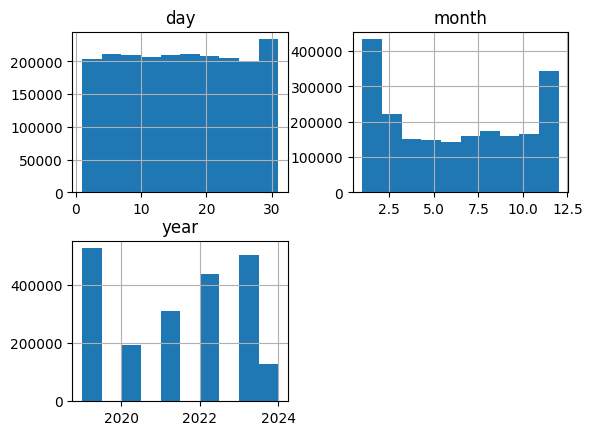

In [203]:
df_final[['day', 'month', 'year']].hist()

In [204]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2101368 entries, 0 to 2101368
Data columns (total 34 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   date                       datetime64[ns]
 1   time_utc                   datetime64[ns]
 2   flight_type                object        
 3   airline_name               object        
 4   aircraft                   object        
 5   passengers                 int64         
 6   pax                        object        
 7   day                        int32         
 8   month                      int32         
 9   year                       int32         
 10  landing                    int64         
 11  international_flight       int64         
 12  airport_origin             object        
 13  airport_destination        object        
 14  type_origin                object        
 15  name_origin                object        
 16  latitude_deg_origin        float64       

In [205]:
df_final['airline_name'].value_counts()

airline_name
0                                           667002
AEROLINEAS ARGENTINAS SA                    635980
unknown                                     178289
FB LÍNEAS AÉREAS - FLYBONDI                 110251
AUSTRAL LINEAS AEREAS-CIELOS DEL SUR S.A    109528
                                             ...  
SMART AVIATION                                   1
TRANSPORTES LUFT LTDA                            1
VENTO SA                                         1
TUIM EMPREENDIMENTOS INMOBILIARIOS LTDA          1
TAXI AEREO HERCULES                              1
Name: count, Length: 2330, dtype: int64

# Change log

04/2024 Version 1.0